# Simulation

This is all the code for the simulation of the market, including the traders, the asset and the market mechanism.

In [324]:
import numpy as np #import relevant packages
import pandas as pd
import matplotlib.pyplot as plt
import math
import csv
from collections import namedtuple

We start by initialising the trading asset, as well as 100 previous random prices so that traders have some material to make their initial trading decisions. These random prices will be kept constant throughout simulations so they don't affect the decisions of the traders between runs. The price at t=0 will be 100 so price movements during the simulation are normalised to an index.

,trading_price,volume,spread,true_price,10_MA,50_MA
-99,96.99,0,0,100,NaN,NaN
-98,97.27,0,0,100,NaN,NaN
-97,95.30,0,0,100,NaN,NaN
-96,95.18,0,0,100,NaN,NaN
-95,94.01,0,0,100,NaN,NaN
-94,93.70,0,0,100,NaN,NaN
-93,92.33,0,0,100,NaN,NaN
-92,91.88,0,0,100,NaN,NaN
-91,92.85,0,0,100,NaN,NaN
-90,92.85,0,0,100,94.24,NaN


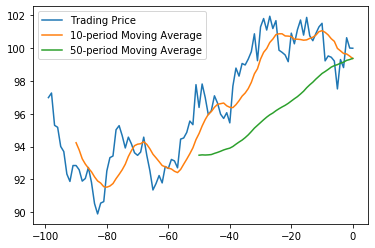

In [337]:
t = 100
period = []
start = -t+1

for i in range(t):
    period.append(start)
    start += 1
    
# asset_prices_rev = []
# price = 100

# for i in range(t):
    # asset_prices_rev.append(price)
    # price = price + np.random.normal(loc=-0.09, scale=1.0, size=None)
    
asset_prices_rev_final = [100, 100.01270443267846, 100.64019372161697, 98.81839318571531, 99.30899479777956, 97.51859080046586, 99.22427385535754, 99.44545557876086, 99.52622326159883, 99.23209122576705, 101.52132601414174, 101.30141646048006, 100.89710059388699, 100.46473999622577, 100.75961538456453, 101.88499554537094, 100.80411278857896, 101.72248034025961, 101.12565566539686, 100.26632483034365, 100.91562712976665, 99.17772539309188, 99.59066814732586, 99.75049301170291, 99.88257405096272, 101.67780729403768, 101.20291667999382, 101.94670634215417, 101.10767031065018, 101.81291988910793, 101.30365747376271, 99.2424041923615, 100.8833495441585, 99.78836505154021, 99.33535482264746, 98.97871646915819, 99.06522794959744, 98.30142009719744, 98.79170348115102, 97.6910991393464, 95.44595047877094, 96.06814982285735, 95.72056059028928, 95.98006873492281, 96.66174879041085, 97.10418900617363, 96.20190098646628, 95.95299800697686, 96.99590538116517, 97.81622741995606, 96.3887487724033, 97.77586186321399, 95.34063768966071, 95.55822196174113, 94.86914074199406, 94.52574130209447, 94.46441233699015, 92.7093912019743, 93.12968534010358, 93.2223145464527, 92.66989504822202, 92.78906639898042, 91.794571679981, 92.23728712947086, 91.7531808557108, 91.36069829889261, 92.5351177867759, 93.46525633285206, 94.57936577428167, 93.6743842774735, 93.47493406493045, 93.6252878884862, 94.17103159031704, 94.57988577655658, 93.92021148266691, 94.66830817347167, 95.2828076714649, 95.03199804355003, 93.43284668672827, 93.33299029582979, 92.51972813503856, 90.65244342293956, 90.55553325883402, 89.89860870807794, 90.5321278206722, 91.82820852517096, 92.73328391342815, 92.05545521924738, 91.89793090418809, 92.59268573869126, 92.84506087167615, 92.8490494107132, 91.88331933594272, 92.3255816844502, 93.70032141468926, 94.00839921394368, 95.17675414492784, 95.29954443407748, 97.27212940879878, 96.98808834932551]

asset_prices_rev_final.reverse()

asset_prices_rev_final_rounded = []

for i in asset_prices_rev_final:
    j = round(i, 2)
    asset_prices_rev_final_rounded.append(j)
    
asset_prices = asset_prices_rev_final_rounded
        
true_prices = []
    
for i in range(t):
    true_prices.append(100) #Assume true price unchanged in this period - remained 100
    
def evolve(df): # Define the function that determines the evolution of the true asset price over time
    last_price = df.iloc[-1]["true_price"]
    ret = (1.05)**(1/50)
    base_price = last_price*ret #The true price evolves to give a 5% return every 100 periods
    shock_p = np.random.randint(100, size=1) #There are some shocks to the true price, some large and some small
    shock = 0
    if shock_p < 5:
        shock = np.random.normal(loc=0, scale=1.5, size=None)
    elif shock_p > 5 and shock_p < 30:
        shock = np.random.normal(loc=0, scale=0.25, size=None)
    next_price = round((base_price + shock), 2)
    return next_price
    
def moving_average_list(price_list, window): #Define a function to calculate simple moving averages
    window_size = window
    price_series = pd.Series(price_list)
    windows = price_series.rolling(window_size)
    ma = round(windows.mean(), 2)
    ma_list = ma.tolist()
    return ma_list
    
mas = moving_average_list(asset_prices, 10) #Generate shorter moving average
mal = moving_average_list(asset_prices, 50) #Generate longer moving average

vol_list = []
spread_list = []
for i in range(100):
    vol_list.append(0)
    spread_list.append(0)

#assetdf = pd.DataFrame(data={"trading_price": asset_prices, "true_price": true_prices, "10_MA": mas, "50_MA": mal}, index=period)
assetdf = pd.DataFrame(data={"trading_price": asset_prices, "volume": vol_list, "spread": spread_list, "true_price": true_prices, "10_MA": mas, "50_MA": mal}, index=period)

plt.plot(assetdf.index, assetdf["trading_price"], label="Trading Price")
plt.plot(assetdf.index, assetdf["10_MA"], label="10-period Moving Average")
plt.plot(assetdf.index, assetdf["50_MA"], label="50-period Moving Average")
plt.legend()
assetdf

In the next cell we define the different flavours of traders and the syntax of how they receive information and place orders accordingly. Flavours include chartists ("chart"), fundamentalists/arbitrageurs ("arb"), value traders ("val") and noise traders ("noise"). The LSTM traders will be included later once a working market has been established.

Chartists represent the technical analysts of the world. They have 2 indicators (based solely on the previous prices of the asset) from which they base their expectations of market development. The indicators are moving averages which assess the trend of price-action (when the shorter period MA crosses the larger one that indicates a shift in trend). While the reliability of these indicators are empirically ambiguous in academic circles, they are widely used across technical analysts in the retail trading community.

Fundamentalists exist to constantly provide pressure towards the "true" price of the asset. They will act as arbitrageurs to push the price towards the true price of the asset. The further away price deviates from the "true" price, the higher the order size grows as they believe the asset is truly under/overvalued. For the purposes of simplicity, a true price will be given exogenously, and will evolve linearly with some random shocks. Value traders are those that believe "time in the market beats timing the market" and will buy and hold the asset over time. They expect to make their returns over the long term based on the true price of the asset growing (and the trading price reflecting this).

Noise traders have no specific strategy and simply buy and sell at random to provide volume in the market. The real world equivalent for this could be considered to be uninformed retail traders.

In [316]:
def w(p): # Define the probability weighting function (prospect theory) for the utility of the traders
    g = 0.5 # G for gamma (0.5 taken from empirical studies)
    return (p**g)/((p**g+(1-p)**g)**(1/g))

#def v(x): #Define the value function (prospect theory) for the utility of the traders
#    a = 0.44 # a for alpha (all parameter values have been taken from empirical studies)
#    b = 0.49 # b for beta
#    l = 1.06 # l for lambda
#    if x >= 0:
#        v = x**a
#    elif x < 0:
#        v = -l(-x)**b
#    return v

def sigmoid(x): #Used to transform inputs in range (-inf,inf) to (0,1) for probabilities
    return 1/(1 + np.exp(-x))

class Trader:
    
    def v(self, x): #Define the value function (prospect theory) for the utility of the traders
        self.x = x
#        self.val = 0
        self.a = 0.44 # a for alpha (all parameter values have been taken from empirical studies)
        self.b = 0.49 # b for beta
        self.l = 1.06 # l for lambda
        if self.x >= 0:
            self.val = self.x**self.a
        elif self.x < 0:
            self.val = -self.l*(-self.x)**self.b
        return self.val
                        
    def __init__(self, flavour, ID):
        self.flavour = flavour     
        self.activ = np.random.uniform() #Activation frequency of each trader
        self.bal = 5_000
        self.tp_error = np.random.normal(loc=0, scale=1.5, size=None)
        self.stock = 50
        self.scale = np.random.uniform(low=1, high=2) #The scale by which order sizes are increased above utility
        self.acc = self.stock*100 + self.bal # Account size equals value of stock + value of cash balance            
        self.id = "id" + str(ID)
        self.faith = np.random.uniform() #The proclivity of the agent to stick to its current trading strategy
        self.back = round(10*self.faith) #How far back chartists go to determine returns
        self.val = 0
        self.util = 0
        
    def placebid(self): #Bid needs to be made in the form bid = (quantity, price, userID, isBuying=True)
        
        if self.flavour == "arb" or "chart":
            self.bidprice = round(assetdf.iloc[-1]["trading_price"] + self.faith, 2)
            self.quantity = round(self.util*self.scale)
            
        elif self.flavour == "val":
            self.bidprice = round(assetdf.iloc[-1]["trading_price"] + self.faith, 2)
            self.quantity = round((self.acc/self.bidprice)/100)
            
        elif self.flavour == "noise":
            self.bidprice = round(np.random.normal(loc=(assetdf.iloc[-1]["trading_price"]), scale = 0.75, size = None), 2)
            self.quantity = abs(round(np.random.normal(loc=(self.stock/100), scale=3, size=None)))
        
        if self.quantity*self.bidprice > self.bal:
            self.quantity = math.floor(self.bal/self.bidprice)
        if self.quantity < 1:
            self.quantity = 1
        self.bid = (self.quantity, self.bidprice, self.id, True)
        return self.bid
        
    def placeask(self): #Same form as bids but with isBuying=False
            
        if self.flavour == "arb" or "chart":
            self.askprice = round(assetdf.iloc[-1]["trading_price"] - self.faith, 2)
            self.quantity = round(self.util*self.scale)
            
        elif self.flavour == "val":
            self.askprice = round(assetdf.iloc[-1]["trading_price"] - self.faith, 2)
            self.quantity = round(self.stock/2)
            
        elif self.flavour == "noise":
            self.askprice = round(np.random.normal(loc=(assetdf.iloc[-1]["trading_price"]), scale = 0.75, size = None), 2)
            self.quantity = abs(round(np.random.normal(loc=(self.stock/100), scale=3, size=None)))

        if self.quantity < 1:
            self.quantity = 1            
        if self.quantity > self.stock:
            self.quantity = self.stock
        self.ask = (self.quantity, self.askprice, self.id, False)
        return self.ask
                        
    def trade(self):
        if self.flavour == "chart":
            if assetdf.iloc[-1]["10_MA"] > assetdf.iloc[-1]["50_MA"]:
                self.xgood = assetdf["trading_price"].max() - assetdf.iloc[-1]["trading_price"]
                self.xbad = assetdf.iloc[-1]["50_MA"] - assetdf.iloc[-1]["trading_price"]
                self.pgood = sigmoid(100*((assetdf.iloc[-1]["trading_price"]-assetdf.iloc[-(1+self.back)]["trading_price"])/assetdf.iloc[-(1+self.back)]["trading_price"]))
                self.pbad = 1 - self.pgood
                self.lot = self.xgood*w(self.pgood) + self.xbad*w(self.pbad)
                self.util = self.v(self.lot)
                if self.util > 0.5:
                    return self.placebid()
            elif assetdf.iloc[-1]["10_MA"] < assetdf.iloc[-1]["50_MA"]:
                self.xgood = assetdf.iloc[-1]["trading_price"] - assetdf["trading_price"].min()
                self.xbad = assetdf.iloc[-1]["trading_price"] - assetdf.iloc[-1]["50_MA"]
                self.pgood = sigmoid(-100*((assetdf.iloc[-1]["trading_price"]-assetdf.iloc[-(1+self.back)]["trading_price"])/assetdf.iloc[-(1+self.back)]["trading_price"]))
                self.pbad = 1 - self.pgood
                self.lot = self.xgood*w(self.pgood) + self.xbad*w(self.pbad)
                self.util = self.v(self.lot)
                if self.util > 0.5:
                    return self.placeask()
            
        elif self.flavour == "arb":
            if assetdf.iloc[-1]["trading_price"] < assetdf.iloc[-1]["true_price"] + self.tp_error:
                self.xgood = assetdf.iloc[-1]["true_price"] + self.tp_error - assetdf.iloc[-1]["trading_price"]
                self.xbad = assetdf.iloc[-1]["trading_price"] - assetdf["trading_price"].min()
                self.pgood = (assetdf.iloc[-1]["true_price"] + self.tp_error - assetdf.iloc[-1]["trading_price"])/(assetdf.iloc[-1]["true_price"] + self.tp_error - assetdf["trading_price"].min())
                self.pbad = 1 - self.pgood
                self.lot = self.xgood*w(self.pgood) + self.xbad*w(self.pbad)
#                print(self.lot)
                self.util = self.v(self.lot)
#                print("util = " + str(self.util))
                if self.util > 0.5:
                    return self.placebid()
            elif assetdf.iloc[-1]["trading_price"] > assetdf.iloc[-1]["true_price"] + self.tp_error:
                self.xgood = assetdf.iloc[-1]["trading_price"] - assetdf.iloc[-1]["true_price"] + self.tp_error
                self.xbad = assetdf.iloc[-1]["trading_price"] - assetdf["trading_price"].max()
                self.pgood = (assetdf.iloc[-1]["trading_price"] - assetdf.iloc[-1]["true_price"] + self.tp_error)/(assetdf["trading_price"].max() - assetdf.iloc[-1]["true_price"] + self.tp_error)
                self.lot = self.xgood*w(self.pgood) + self.xbad*w(self.xbad)
                self.util = self.v(self.lot)
#                print("util = " + str(self.util))
                if self.util > 0.5:
                    return self.placeask()

        elif self.flavour == "val":
            if self.activ > activ_rate:
                if assetdf.iloc[-1]["trading_price"] >= assetdf["trading_price"].max():
                    return self.placeask()
                else:
                    return self.placebid()
            else:
                pass
                    
        elif self.flavour == "noise":
            if self.activ > activ_rate:
                x = np.random.normal(loc=0, scale = 1, size = None)
                if x > 0:
                    return self.placebid()
                if x < 0:
                    return self.placeask()
            else:
                pass

Next we set up the environment for the market. The market will use a simple peer-to-peer exchange mechanism, where the orders are ranked from highest to least price and then matched as best as possible. Aggressive bids/asks are more likely to secure the desired trade volume but come at a cost of giving up more potential surplus (NB: currently unfinished).

In [232]:
traders_set = []
id_dict = {}

def gen_traders():
    traders_set.clear()
    id_dict.clear()
    t1 = Trader("arb", 1)
    t2 = Trader("arb", 2)
    t3 = Trader("arb", 3)
    t4 = Trader("arb", 4)
    t5 = Trader("arb", 5)
    t6 = Trader("arb", 6)
    t7 = Trader("arb", 7)
    t8 = Trader("arb", 8)
    t9 = Trader("arb", 9)
    t10 = Trader("arb", 10)
    t11 = Trader("arb", 11)
    t12 = Trader("arb", 12)
    t13 = Trader("arb", 13)
    t14 = Trader("arb", 14)
    t15 = Trader("arb", 15)
    t16 = Trader("arb", 16)
    t17 = Trader("arb", 17)
    t18 = Trader("arb", 18)
    t19 = Trader("arb", 19)
    t20 = Trader("arb", 20)
    t21 = Trader("arb", 21)
    t22 = Trader("arb", 22)
    t23 = Trader("arb", 23)
    t24 = Trader("arb", 24)
    t25 = Trader("arb", 25)
    t26 = Trader("chart", 26)
    t27 = Trader("chart", 27)
    t28 = Trader("chart", 28)
    t29 = Trader("chart", 29)
    t30 = Trader("chart", 30)
    t31 = Trader("chart", 31)
    t32 = Trader("chart", 32)
    t33 = Trader("chart", 33)
    t34 = Trader("chart", 34)
    t35 = Trader("chart", 35)
    t36 = Trader("chart", 36)
    t37 = Trader("chart", 37)
    t38 = Trader("chart", 38)
    t39 = Trader("chart", 39)
    t40 = Trader("chart", 40)
    t41 = Trader("chart", 41)
    t42 = Trader("chart", 42)
    t43 = Trader("chart", 43)
    t44 = Trader("chart", 44)
    t45 = Trader("chart", 45)
    t46 = Trader("chart", 46)
    t47 = Trader("chart", 47)
    t48 = Trader("chart", 48)
    t49 = Trader("chart", 49)
    t50 = Trader("chart", 50)
    t51 = Trader("val", 51)
    t52 = Trader("val", 52)
    t53 = Trader("val", 53)
    t54 = Trader("val", 54)
    t55 = Trader("val", 55)
    t56 = Trader("val", 56)
    t57 = Trader("val", 57)
    t58 = Trader("val", 58)
    t59 = Trader("val", 59)
    t60 = Trader("val", 60)
    t61 = Trader("val", 61)
    t62 = Trader("val", 62)
    t63 = Trader("val", 63)
    t64 = Trader("val", 64)
    t65 = Trader("val", 65)
    t66 = Trader("val", 66)
    t67 = Trader("val", 67)
    t68 = Trader("val", 68)
    t69 = Trader("val", 69)
    t70 = Trader("val", 70)
    t71 = Trader("val", 71)
    t72 = Trader("val", 72)
    t73 = Trader("val", 73)
    t74 = Trader("val", 74)
    t75 = Trader("val", 75)
    t76 = Trader("noise", 76)
    t77 = Trader("noise", 77)
    t78 = Trader("noise", 78)
    t79 = Trader("noise", 79)
    t80 = Trader("noise", 80)
    t81 = Trader("noise", 81)
    t82 = Trader("noise", 82)
    t83 = Trader("noise", 83)
    t84 = Trader("noise", 84)
    t85 = Trader("noise", 85)
    t86 = Trader("noise", 86)
    t87 = Trader("noise", 87)
    t88 = Trader("noise", 88)
    t89 = Trader("noise", 89)
    t90 = Trader("noise", 90)
    t91 = Trader("noise", 91)
    t92 = Trader("noise", 92)
    t93 = Trader("noise", 93)
    t94 = Trader("noise", 94)
    t95 = Trader("noise", 95)
    t96 = Trader("noise", 96)
    t97 = Trader("noise", 97)
    t98 = Trader("noise", 98)
    t99 = Trader("noise", 99)
    t100 = Trader("noise", 100)
    traders_set.append(t1)
    traders_set.append(t2)
    traders_set.append(t3)
    traders_set.append(t4)
    traders_set.append(t5)
    traders_set.append(t6)
    traders_set.append(t7)
    traders_set.append(t8)
    traders_set.append(t9)
    traders_set.append(t10)
    traders_set.append(t11)
    traders_set.append(t12)
    traders_set.append(t13)
    traders_set.append(t14)
    traders_set.append(t15)
    traders_set.append(t16)
    traders_set.append(t17)
    traders_set.append(t18)
    traders_set.append(t19)
    traders_set.append(t20)
    traders_set.append(t21)
    traders_set.append(t22)
    traders_set.append(t23)
    traders_set.append(t24)
    traders_set.append(t25)
    traders_set.append(t26)
    traders_set.append(t27)
    traders_set.append(t28)
    traders_set.append(t29)
    traders_set.append(t30)
    traders_set.append(t31)
    traders_set.append(t32)
    traders_set.append(t33)
    traders_set.append(t34)
    traders_set.append(t35)
    traders_set.append(t36)
    traders_set.append(t37)
    traders_set.append(t38)
    traders_set.append(t39)
    traders_set.append(t40)
    traders_set.append(t41)
    traders_set.append(t42)
    traders_set.append(t43)
    traders_set.append(t44)
    traders_set.append(t45)
    traders_set.append(t46)
    traders_set.append(t47)
    traders_set.append(t48)
    traders_set.append(t49)
    traders_set.append(t50)
    traders_set.append(t51)
    traders_set.append(t52)
    traders_set.append(t53)
    traders_set.append(t54)
    traders_set.append(t55)
    traders_set.append(t56)
    traders_set.append(t57)
    traders_set.append(t58)
    traders_set.append(t59)
    traders_set.append(t60)
    traders_set.append(t61)
    traders_set.append(t62)
    traders_set.append(t63)
    traders_set.append(t64)
    traders_set.append(t65)
    traders_set.append(t66)
    traders_set.append(t67)
    traders_set.append(t68)
    traders_set.append(t69)
    traders_set.append(t70)
    traders_set.append(t71)
    traders_set.append(t72)
    traders_set.append(t73)
    traders_set.append(t74)
    traders_set.append(t75)
    traders_set.append(t76)
    traders_set.append(t77)
    traders_set.append(t78)
    traders_set.append(t79)
    traders_set.append(t80)
    traders_set.append(t81)
    traders_set.append(t82)
    traders_set.append(t83)
    traders_set.append(t84)
    traders_set.append(t85)
    traders_set.append(t86)
    traders_set.append(t87)
    traders_set.append(t88)
    traders_set.append(t89)
    traders_set.append(t90)
    traders_set.append(t91)
    traders_set.append(t92)
    traders_set.append(t93)
    traders_set.append(t94)
    traders_set.append(t95)
    traders_set.append(t96)
    traders_set.append(t97)
    traders_set.append(t98)
    traders_set.append(t99)
    traders_set.append(t100)

    for participant in traders_set:
        id_dict[participant.id] = participant

In [325]:
TraderNumbers = namedtuple("NumberTraders", "Arb_Traders Chart_Traders Val_Traders Noise_Traders".split())
n_traders = TraderNumbers(25, 25, 25, 25)
TRADERS_INDICES = np.cumsum(n_traders)

def choose_trader(idx):
    if idx <= TRADERS_INDICES[0]:
        return Trader("arb", idx)
    elif TRADERS_INDICES[0] < idx <= TRADERS_INDICES[1]:
        return Trader("chart", idx)
    elif TRADERS_INDICES[1] < idx <= TRADERS_INDICES[2]:
        return Trader("val", idx)
    return Trader("noise", idx)
    
def gen_traders():
    traders_set = [choose_trader(i) for i in range(TRADERS_INDICES[-1])]
    id_dict = {participant.id: participant for participant in traders_set}
    return traders_set, id_dict

In [194]:
def run_market(bids, asks, iddict, traders_set):
    bidsdf = pd.DataFrame(bids, columns=["q", "p", "id", "buy"])
    asksdf = pd.DataFrame(asks, columns=["q", "p", "id", "buy"])
    bidsdf = bidsdf.drop(columns=["buy"])
    asksdf = asksdf.drop(columns=["buy"])
    bidsdf = bidsdf.sort_values(by=["p", "q"], ascending=False)
    asksdf = asksdf.sort_values(by=["p", "q"], ascending=False)
    bidsdf = bidsdf.reset_index(drop=True)
    asksdf = asksdf.reset_index(drop=True)
    bal_data = []
    for participant in traders_set:
        row = [participant.id, participant.stock, participant.bal, participant.acc, participant.flavour]
        bal_data.append(row)
    tradersdf1 = pd.DataFrame(data=bal_data, columns=["id", "stock", "bal", "acc", "flavour"])

    traded_val = []
    volume = 0
    spread = round(bidsdf.iloc[0]["p"] - asksdf.iloc[-1]["p"], 2)

    while len(bidsdf) !=0 and len(asksdf) !=0:
        buyer_id = bidsdf.iloc[0]["id"]
        seller_id = asksdf.iloc[0]["id"]
        if bidsdf.iloc[0]["p"] == asksdf.iloc[0]["p"]:
            price = round(bidsdf.iloc[0]["p"], 2)
        else:
            price = round((bidsdf.iloc[0]["p"] + asksdf.iloc[0]["p"])/2, 2)
        if bidsdf.iloc[0]["q"] == asksdf.iloc[0]["q"]:
            quantity = bidsdf.iloc[0]["q"]
        elif bidsdf.iloc[0]["q"] < asksdf.iloc[0]["q"]:
            quantity = bidsdf.iloc[0]["q"]
        elif bidsdf.iloc[0]["q"] > asksdf.iloc[0]["q"]:
            quantity = asksdf.iloc[0]["q"]

        iddict[str(buyer_id)].stock += quantity
        iddict[str(seller_id)].stock -= quantity
        iddict[str(buyer_id)].bal -= price*quantity
        iddict[str(seller_id)].bal += price*quantity
        volume += quantity
        traded_val.append(price*quantity)

        if bidsdf.iloc[0]["q"] == asksdf.iloc[0]["q"]:
            bidsdf = bidsdf.drop(bidsdf.index[0])
            asksdf = asksdf.drop(asksdf.index[0])
        elif bidsdf.iloc[0]["q"] < asksdf.iloc[0]["q"]:
            asksdf.at[0, "q"] = asksdf.iloc[0]["q"] - bidsdf.iloc[0]["q"]
            bidsdf = bidsdf.drop(bidsdf.index[0])
        elif bidsdf.iloc[0]["q"] > asksdf.iloc[0]["q"]:
            bidsdf.at[0, "q"] = bidsdf.iloc[0]["q"] - asksdf.iloc[0]["q"]
            asksdf = asksdf.drop(asksdf.index[0])
        bidsdf = bidsdf.reset_index(drop=True)
        asksdf = asksdf.reset_index(drop=True)

    total = sum(traded_val)
    avg_price = round((total/volume), 2)
#    print(bidsdf)
#    print(asksdf)

    for participant in traders_set:
        participant.acc = participant.bal + (participant.stock*avg_price)

    bal_data_new = []
    for participant in traders_set:
        row = [participant.id, participant.stock, participant.bal, participant.acc, participant.flavour]
        bal_data_new.append(row)
    tradersdf2 = pd.DataFrame(data=bal_data_new, columns=["id", "stock", "bal", "acc", "flavour"])
    return {"trading_price": avg_price, "volume": volume, "spread": spread}, tradersdf1, tradersdf2

In [195]:
"""NEW MECHANISM"""
def run_market(bids, asks, iddict, traders_set):
    bidsdf = pd.DataFrame(bids, columns=["q", "p", "id", "buy"])
    asksdf = pd.DataFrame(asks, columns=["q", "p", "id", "buy"])
    bidsdf = bidsdf.drop(columns=["buy"])
    asksdf = asksdf.drop(columns=["buy"])
    bidsdf = bidsdf.sort_values(by=["p", "q"], ascending=False)
    asksdf = asksdf.sort_values(by=["p", "q"], ascending=False)
    bidsdf = bidsdf.reset_index(drop=True)
    asksdf = asksdf.reset_index(drop=True)
    bal_data = []
    for participant in traders_set:
        row = [participant.id, participant.stock, participant.bal, participant.acc, participant.flavour]
        bal_data.append(row)
    tradersdf1 = pd.DataFrame(data=bal_data, columns=["id", "stock", "bal", "acc", "flavour"])

    traded_val = []
    volume = 0
    spread = round(bidsdf.iloc[0]["p"] - asksdf.iloc[-1]["p"], 2)

    while len(bidsdf) !=0 and len(asksdf) !=0:
        buyer_id = bidsdf.iloc[0]["id"]
        seller_id = asksdf.iloc[0]["id"]
        if bidsdf.iloc[0]["p"] == asksdf.iloc[0]["p"]:
            price = round(bidsdf.iloc[0]["p"], 2)
        else:
            price = round((bidsdf.iloc[0]["p"] + asksdf.iloc[0]["p"])/2, 2)
        if bidsdf.iloc[0]["q"] == asksdf.iloc[0]["q"]:
            quantity = bidsdf.iloc[0]["q"]
        elif bidsdf.iloc[0]["q"] < asksdf.iloc[0]["q"]:
            quantity = bidsdf.iloc[0]["q"]
        elif bidsdf.iloc[0]["q"] > asksdf.iloc[0]["q"]:
            quantity = asksdf.iloc[0]["q"]

        iddict[str(buyer_id)].stock += quantity
        iddict[str(seller_id)].stock -= quantity
        iddict[str(buyer_id)].bal -= price*quantity
        iddict[str(seller_id)].bal += price*quantity
        volume += quantity
        traded_val.append(price*quantity)

        if bidsdf.iloc[0]["q"] == asksdf.iloc[0]["q"]:
            bidsdf = bidsdf.drop(bidsdf.index[0])
            asksdf = asksdf.drop(asksdf.index[0])
        elif bidsdf.iloc[0]["q"] < asksdf.iloc[0]["q"]:
            asksdf.at[0, "q"] = asksdf.iloc[0]["q"] - bidsdf.iloc[0]["q"]
            bidsdf = bidsdf.drop(bidsdf.index[0])
        elif bidsdf.iloc[0]["q"] > asksdf.iloc[0]["q"]:
            bidsdf.at[0, "q"] = bidsdf.iloc[0]["q"] - asksdf.iloc[0]["q"]
            asksdf = asksdf.drop(asksdf.index[0])
        bidsdf = bidsdf.reset_index(drop=True)
        asksdf = asksdf.reset_index(drop=True)

    remaining_val = 0  
    remaining_vol = 0
    if len(bidsdf) == 0 and len(asksdf) > 0:
        sign = -1
        remaining_vol = asksdf["q"].sum()
        for index, row in asksdf.iterrows():
            remaining_val += row["p"]*row["q"]
    elif len(bidsdf) > 0 and len(asksdf) == 0:
        sign = 1
        remaining_vol = bidsdf["q"].sum()
        for index, row in bidsdf.iterrows():
            remaining_val += row["p"]*row["q"]
    if len(bidsdf) != 0 or len(asksdf) != 0:
        remaining_avg = remaining_val/remaining_vol
        if remaining_vol/volume < 1:
            b = (remaining_vol/volume)*abs(remaining_avg - assetdf.iloc[-1]["trading_price"])
        else:
            b = abs(remaining_avg - assetdf.iloc[-1]["trading_price"])
        clearing_price = round(assetdf.iloc[-1]["trading_price"] + sign*b, 2)
    elif len(bidsdf) == 0 and len(asksdf) == 0:
        clearing_price = round(assetdf.iloc[-1]["trading_price"], 2)

    for participant in traders_set:
        participant.acc = participant.bal + (participant.stock*clearing_price)

    bal_data_new = []
    for participant in traders_set:
        row = [participant.id, participant.stock, participant.bal, participant.acc, participant.flavour]
        bal_data_new.append(row)
    tradersdf2 = pd.DataFrame(data=bal_data_new, columns=["id", "stock", "bal", "acc", "flavour"])
    return {"trading_price": clearing_price, "volume": volume, "spread": spread}, tradersdf1, tradersdf2

In [338]:
""" NEW MARKET MECHANISM"""
def run_market(bids_list, asks_list, iddict, traders_set):
    bidsdf = pd.DataFrame(bids, columns=["b_q", "b_p", "b_id", "buy"])
    asksdf = pd.DataFrame(asks, columns=["a_q", "a_p", "a_id", "buy"])
    bidsdf = bidsdf.drop(columns=["buy"])
    asksdf = asksdf.drop(columns=["buy"])
    bidsdf = bidsdf.sort_values(by=["b_p", "b_q", "b_id"], ascending=False)
    asksdf = asksdf.sort_values(by=["a_p", "a_q", "a_id"], ascending=True)
    bidsdf = bidsdf.reset_index(drop=True)
    asksdf = asksdf.reset_index(drop=True)
    bidsdf1 = bidsdf.copy()
    asksdf1 = asksdf.copy()
    
    bal_data = []
    for participant in traders_set:
        row = [participant.id, participant.stock, participant.bal, participant.acc, participant.flavour]
        bal_data.append(row)
    tradersdf1 = pd.DataFrame(data=bal_data, columns=["id", "stock", "bal", "acc", "flavour"])
    
    singlebidlist = []
    for index, row in bidsdf1.iterrows():
        while row["b_q"] > 1:
            singlebidlist.append({"b_q": 1, "b_p": row["b_p"], "b_id": row["b_id"]})
            row["b_q"] -= 1
        bidsdf1.at[index, "b_q"] = 1
    for i in singlebidlist:
        bidsdf1 = bidsdf1.append(i, ignore_index=True)
    bidsdf1 = bidsdf1.sort_values(by=["b_p", "b_q"], ascending=False)
    
    singleasklist = []
    for index, row in asksdf1.iterrows():
        while row["a_q"] > 1:
            singleasklist.append({"a_q": 1, "a_p": row["a_p"], "a_id": row["a_id"]})
            row["a_q"] -= 1
        asksdf1.at[index, "a_q"] = 1
    for i in singleasklist:
        asksdf1 = asksdf1.append(i, ignore_index=True)
    asksdf1 = asksdf1.sort_values(by=["a_p", "a_q"], ascending=True)
    
    clearing_price = 0
    clearing_index = 0
    bidscopy = bidsdf1.copy()
    askscopy = asksdf1.copy()
    bidscopy = bidscopy.reset_index(drop=True)
    askscopy = askscopy.reset_index(drop=True)
    totaldf = pd.concat([bidscopy, askscopy], axis=1, sort=False)
    
    for index, row in totaldf.iterrows():
        if math.isnan(row["b_p"]):
            clearing_price = totaldf.iloc[index-1]["a_p"]
            clearing_index = index - 1
            break
        elif math.isnan(row["a_p"]):
            clearing_price = totaldf.iloc[index-1]["b_p"]
            clearing_index = index - 1
            break
        elif row["b_p"] < row["a_p"]:
            lastask = totaldf.iloc[index-1]["a_p"]
            nextbid = totaldf.iloc[index]["b_p"]
            if lastask > nextbid:
                clearing_price = lastask
                clearing_index = index - 1
                break
            elif lastask <= nextbid:
                clearing_price = nextbid
                clearing_index = index - 1
                break
                
#    print(clearing_price)
#    print(clearing_index)
    
    for index, row in totaldf.iterrows():
        iddict[str(row["b_id"])].stock += 1
        iddict[str(row["a_id"])].bal += clearing_price
        iddict[str(row["b_id"])].bal -= clearing_price
        iddict[str(row["a_id"])].stock -= 1
#        print(str(index) + "trade done")
        if index == clearing_index:
            break
            
    for participant in traders_set:
        participant.acc = participant.stock*clearing_price + participant.bal
        
    spread = totaldf.iloc[0]["b_p"] - totaldf.iloc[0]["a_p"]
    
    bal_data_new = []
    for participant in traders_set:
        row = [participant.id, participant.stock, participant.bal, participant.acc, participant.flavour]
        bal_data_new.append(row)
    tradersdf2 = pd.DataFrame(data=bal_data_new, columns=["id", "stock", "bal", "acc", "flavour"])
    
    statistics = {"trading_price": clearing_price, "volume": clearing_index, "spread": spread}    
    
    return statistics, tradersdf1, tradersdf2

In [314]:
def staticma(short, window):
    newma = 0
    if short:
        newma = assetdf.iloc[-1]["10_MA"] + (1/(window))*(stats["trading_price"]-assetdf.iloc[-(window+1)]["trading_price"])
    else:
        newma = assetdf.iloc[-1]["50_MA"] + (1/(window))*(stats["trading_price"]-assetdf.iloc[-(window+1)]["trading_price"])
    return newma

def mutate(statedf):
    #Get top performer
    #Change to top performer if desired
    topacc = 0
    topflavour = "None"
    for i, j in enumerate(statedf["acc"]):
        if j > topacc:
            topacc = j
            topflavour = statedf.iloc[i]["flavour"]
    for trader in traders_set:
        if trader.faith < faith_rate:
            trader.flavour = topflavour

In [339]:
traders_set, id_dict = gen_traders()

for t in range(1,51):
    for participant in traders_set:
        if participant.stock == 0 and participant.bal < assetdf.iloc[-1]["trading_price"]:
            traders_set.remove(participant)
    bids = []
    asks = []
    activ_rate = np.random.uniform()
    faith_rate = np.random.uniform()
    for participant in traders_set:
        order = participant.trade()
        if type(order) == tuple and order[3] == True and order[0] != 0:
            bids.append(order)
        if type(order) == tuple and order[3] == False and order[0] != 0:
            asks.append(order)
    if len(bids) == 0 or len(asks) == 0: continue
    stats, state0, state1 = run_market(bids, asks, id_dict, traders_set)
    next_price = evolve(assetdf)
    shortma = staticma(True, 10)
    longma = staticma(False, 50)
    stats["true_price"] = next_price
    stats["10_MA"] = shortma
    stats["50_MA"] = longma
    appendlist = []
    for k,v in stats.items():
        appendlist.append(v)
    assetdf.loc[t] = appendlist
#    assetdf = assetdf.append(stats, ignore_index=False)
    if t%50 == 0:
        for trader in traders_set:
            mutate(state1)

/Users/karangarg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/karangarg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in double_scalars
/Users/karangarg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


,trading_price,volume,spread,true_price,10_MA,50_MA
-99,96.99,0.0,0.00,100.00,NaN,NaN
-98,97.27,0.0,0.00,100.00,NaN,NaN
-97,95.30,0.0,0.00,100.00,NaN,NaN
-96,95.18,0.0,0.00,100.00,NaN,NaN
-95,94.01,0.0,0.00,100.00,NaN,NaN
-94,93.70,0.0,0.00,100.00,NaN,NaN
-93,92.33,0.0,0.00,100.00,NaN,NaN
-92,91.88,0.0,0.00,100.00,NaN,NaN
-91,92.85,0.0,0.00,100.00,NaN,NaN
-90,92.85,0.0,0.00,100.00,94.240,NaN


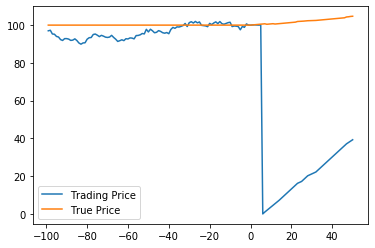

In [340]:
plt.plot(assetdf.index, assetdf["trading_price"], label="Trading Price")
#plt.plot(assetdf.index, assetdf["10_MA"], label="10-period Moving Average")
#plt.plot(assetdf.index, assetdf["50_MA"], label="50-period Moving Average")
plt.plot(assetdf.index, assetdf["true_price"], label="True Price")
plt.legend()
pd.set_option("display.max_rows", None, "display.max_columns", None)
assetdf

In [341]:
print(stats)
print(state0)
print(state1)

{'trading_price': 39.28, 'volume': 80, 'spread': 1.9499999999999957, 'true_price': 104.7, '10_MA': 28.342, '50_MA': 32.64740000000001}
      id  stock      bal       acc flavour
0    id0     50  5000.00   6929.00     arb
1    id1     77  3040.34   6011.00     arb
2    id2    323  -307.22  12154.12     arb
3    id3     58  4199.68   6437.32     arb
4    id4     50  5000.00   6929.00     arb
5    id5     70  4235.60   6936.20     arb
6    id6     65  3498.98   6006.68     arb
7    id7     79  2651.42   5699.24     arb
8    id8     50  5000.00   6929.00     arb
9    id9     81  2575.70   5700.68     arb
10  id10     70  2998.64   5699.24     arb
11  id11     65  3498.98   6006.68     arb
12  id12     62  4541.36   6933.32     arb
13  id13     50  5000.00   6929.00     arb
14  id14     70  2998.64   5699.24     arb
15  id15     60  3999.32   6314.12     arb
16  id16     60  3999.32   6314.12     arb
17  id17    184  1441.97   8540.69     arb
18  id18     63  4006.78   6437.32     arb
19  i

In [336]:
gen_traders()
bids = []
asks = []
activ_rate = np.random.uniform()
faith_rate = np.random.uniform()
for participant in traders_set:
    order = participant.trade()
    if type(order) == tuple and order[3] == True and order[0] != 0:
        bids.append(order)
    if type(order) == tuple and order[3] == False and order[0] != 0:
        asks.append(order)
        
run_market(bids, asks, id_dict, traders_set)

/Users/karangarg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


({'trading_price': 99.27, 'volume': 29, 'spread': 1.9399999999999977},
       id  stock      bal      acc flavour
 0    id0     50  5000.00  5897.00   noise
 1    id1     50  5000.00  5897.00     arb
 2    id2     83  4438.70  5927.72     arb
 3    id3     50  5000.00  5897.00   noise
 4    id4     50  5000.00  5897.00     arb
 5    id5     59  4847.00  5905.46     arb
 6    id6     50  5000.00  5897.00     arb
 7    id7     50  5000.00  5897.00     arb
 8    id8     50  5000.00  5897.00     arb
 9    id9     50  5000.00  5897.00     arb
 10  id10    120  3808.30  5961.10     arb
 11  id11     50  5000.00  5897.00     arb
 12  id12     50  5000.00  5897.00     arb
 13  id13    257  1441.82  6052.40     arb
 14  id14     50  5000.00  5897.00   noise
 15  id15     50  5000.00  5897.00     arb
 16  id16     50  5000.00  5897.00     arb
 17  id17     50  5000.00  5897.00     arb
 18  id18     50  5000.00  5897.00     arb
 19  id19     87  4370.50  5931.28     arb
 20  id20     50  5000.00 